In [15]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

from tqdm import tqdm

In [16]:
# seed 고정 (rand 함수 실행시 같은 결과 나올 수 있도록)
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch

    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(42)

# 1. RNN Layer

In [21]:
# input tensor 선언
# input = torch.ones(5, 3) # seq_size, input_dim
input = torch.ones(11, 5, 3) # batch_size, seq_size, input_dim

# RNN Layer 선언
rnn_layer = nn.RNN(input_size=3, hidden_size=10, batch_first=True)
print(rnn_layer.weight_ih_l0.shape)
print(rnn_layer.bias_ih_l0.shape)
print(rnn_layer.weight_hh_l0.shape)
print(rnn_layer.bias_hh_l0.shape)

# print(rnn_layer.weight_ih_l0)
# print(rnn_layer.bias_ih_l0)
# print(rnn_layer.weight_hh_l0)
# print(rnn_layer.bias_hh_l0)

torch.Size([10, 3])
torch.Size([10])
torch.Size([10, 10])
torch.Size([10])


In [22]:
# output 출력
output, hidden = rnn_layer(input)
print(output.shape)
print(hidden.shape)

torch.Size([11, 5, 10])
torch.Size([1, 11, 10])


# 2. LSTM Layer

In [25]:
# input tensor 정의
# input = torch.ones(7, 3) # seq_size, input_dim
input = torch.ones(11, 7, 3) # batch_size, seq_size, input_dim

# layer 정의
lstm_layer = nn.LSTM(input_size=3, hidden_size=10, batch_first=True)

print(lstm_layer.weight_ih_l0.shape) # 입력/삭제/출력 게이트, hidden state 용 paremeter가 4 종류
print(lstm_layer.bias_ih_l0.shape)
print(lstm_layer.weight_hh_l0.shape)
print(lstm_layer.bias_hh_l0.shape)

# print(lstm_layer.weight_ih_l0)
# print(lstm_layer.bias_ih_l0)
# print(lstm_layer.weight_hh_l0)
# print(lstm_layer.bias_hh_l0)

torch.Size([40, 3])
torch.Size([40])
torch.Size([40, 10])
torch.Size([40])


In [26]:
# output 출력
output, (hidden, cell) = lstm_layer(input)
print(output.shape)
print(hidden.shape)
print(cell.shape)

torch.Size([11, 7, 10])
torch.Size([1, 11, 10])
torch.Size([1, 11, 10])


# 3. Stock Price Prediction

### Naver Stock Web Crawling

In [27]:
from bs4 import BeautifulSoup
import requests

# 웹 크롤링
code = '005930' # 삼성전자 종목코드
url = 'https://finance.naver.com/item/sise_day.naver?code={}'.format(code)
header = {'User-agent':'Mozilla/5.0'}
req = requests.get(url, headers=header)
html = BeautifulSoup(req.text, "lxml")

pgrr = html.find('td', class_='pgRR')
s = pgrr.a['href'].split('=')
last_page = s[-1]

# dataset 구성
df = None

for page in tqdm(range(1, 100)):
    req = requests.get('{}&page={}'.format(url, page), headers=header)
    df = pd.concat([df, pd.read_html(req.text, encoding='euc-kr')[0]], ignore_index=True)

df.head()

100%|██████████| 99/99 [00:56<00:00,  1.74it/s]


,날짜,종가,전일비,시가,고가,저가,거래량
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024.04.09,83600.0,900.0,84500.0,84900.0,83100.0,18342168.0
2,2024.04.08,84500.0,0.0,85200.0,86000.0,84500.0,18953232.0
3,2024.04.05,84500.0,800.0,84500.0,85000.0,83800.0,18883752.0
4,2024.04.04,85300.0,1200.0,85200.0,85500.0,84300.0,25248934.0


### df 전처리

In [28]:
# df 전처리
df.dropna(inplace=True)

# 컬럼명 변경
df.columns = ['Date', 'Close', 'Gap', 'Open', 'High', 'Low', 'Amount']

# 불필요 컬럼 제거
df.drop(['Gap'], axis=1, inplace=True)

# 시간순 정렬
df.sort_values(['Date'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.shape)

(990, 6)


In [30]:
# train / test 분리 (train 만 이용해서 학습 및 추론, test는 모델에 input으로 사용 X(미래 값이므로))
train_df = df.loc[df.Date < '2024.04.03'] # 여기까지만 사용
test_df = df.loc[df.Date >= '2024.04.03'] # 모델 학습이 끝난 뒤에 성능 평가용
print(train_df.tail())
print(test_df)

train_df.drop(['Date'], axis=1, inplace=True)

# scaling
scaler = StandardScaler()
scaler.fit(train_df)
s_train_df = scaler.transform(train_df)
s_test_df = scaler.transform(test_df.drop(['Date'], axis=1))

           Date    Close     Open     High      Low      Amount
980  2024.03.27  79800.0  79200.0  80000.0  79200.0  17424595.0
981  2024.03.28  80800.0  79400.0  81000.0  79200.0  25084812.0
982  2024.03.29  82400.0  81200.0  82500.0  80900.0  27126366.0
983  2024.04.01  82000.0  83200.0  83300.0  82000.0  20116513.0
984  2024.04.02  85000.0  82900.0  85000.0  82900.0  37077944.0
           Date    Close     Open     High      Low      Amount
985  2024.04.03  84100.0  84300.0  85000.0  83500.0  30493347.0
986  2024.04.04  85300.0  85200.0  85500.0  84300.0  25248934.0
987  2024.04.05  84500.0  84500.0  85000.0  83800.0  18883752.0
988  2024.04.08  84500.0  85200.0  86000.0  84500.0  18953232.0
989  2024.04.09  83600.0  84500.0  84900.0  83100.0  18342168.0


<ipython-input-30-7642b49f6960>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.drop(['Date'], axis=1, inplace=True)


### 학습용 Dataset으로 재구성

In [31]:
# Define the window sizes
input_window = 30
output_window = 5

# Create the dataset
data = torch.tensor(s_train_df, dtype=torch.float32)
target = torch.tensor(s_train_df.T[0], dtype=torch.float32)

# Create the input and output sequences
X, Y = [], []
for i in range(len(data) - input_window - output_window + 1):
    X.append(data[i:i+input_window])
    Y.append(target[i+input_window:i+input_window+output_window])

# Create the TensorDataset
dataset = TensorDataset(torch.stack(X), torch.stack(Y))
print(dataset[0][0].shape) # seq_size(30일), input_size(close, Open, high, low, amount)
print(dataset[0][1].shape) # output_size(5일치 Close)

# Create the DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Print the dataset size
print(len(dataloader))

torch.Size([30, 5])
torch.Size([5])
30


### LSTM Net 구성 및 학습

In [32]:
# 모델 선언
class MyForecastingModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MyForecastingModel, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # layer 선언
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, hidden_size//2)
        self.fc2 = nn.Linear(hidden_size//2, output_size)

    def forward(self, x):
        output, (h_out, c_out) = self.lstm(x)
        h_out = h_out.view(-1, self.hidden_size)
        out = F.relu(self.fc1(h_out))
        out = self.fc2(out)
        return out

model = MyForecastingModel(input_size=5, hidden_size=30, output_size=5)

### Training loop

In [33]:
# GPU 지정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
print(model.to(device))
next(model.parameters()).device # model parameter 위치 확인 (cuda or cpu)

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

cpu
MyForecastingModel(
  (lstm): LSTM(5, 30, batch_first=True)
  (fc1): Linear(in_features=30, out_features=15, bias=True)
  (fc2): Linear(in_features=15, out_features=5, bias=True)
)


In [34]:
# Training
num_epoch = 100
losses = []

for epoch in range(num_epoch):
    for i, (inputs, labels) in enumerate(dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        losses.append(loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Print the loss every 100 iterations
        if i % 100 == 0:
            print(f'Epoch: {epoch+1}/{num_epoch}, Iteration: {i+1}/{len(dataloader)}, Loss: {loss.item():.4f}')

Epoch: 1/100, Iteration: 1/30, Loss: 1.0529
Epoch: 2/100, Iteration: 1/30, Loss: 0.5307
Epoch: 3/100, Iteration: 1/30, Loss: 0.2998
Epoch: 4/100, Iteration: 1/30, Loss: 0.3611
Epoch: 5/100, Iteration: 1/30, Loss: 0.1257
Epoch: 6/100, Iteration: 1/30, Loss: 0.0461
Epoch: 7/100, Iteration: 1/30, Loss: 0.0826
Epoch: 8/100, Iteration: 1/30, Loss: 0.0410
Epoch: 9/100, Iteration: 1/30, Loss: 0.0658
Epoch: 10/100, Iteration: 1/30, Loss: 0.0361
Epoch: 11/100, Iteration: 1/30, Loss: 0.0312
Epoch: 12/100, Iteration: 1/30, Loss: 0.0369
Epoch: 13/100, Iteration: 1/30, Loss: 0.0228
Epoch: 14/100, Iteration: 1/30, Loss: 0.0262
Epoch: 15/100, Iteration: 1/30, Loss: 0.0304
Epoch: 16/100, Iteration: 1/30, Loss: 0.0398
Epoch: 17/100, Iteration: 1/30, Loss: 0.0196
Epoch: 18/100, Iteration: 1/30, Loss: 0.0222
Epoch: 19/100, Iteration: 1/30, Loss: 0.0233
Epoch: 20/100, Iteration: 1/30, Loss: 0.0281
Epoch: 21/100, Iteration: 1/30, Loss: 0.0206
Epoch: 22/100, Iteration: 1/30, Loss: 0.0276
Epoch: 23/100, Iter

### Loss 시각화

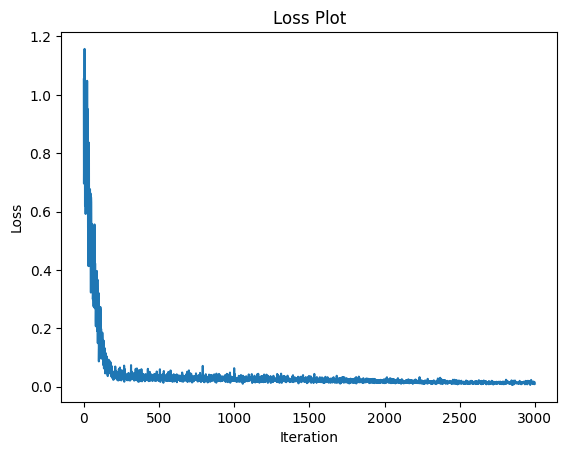

In [35]:
import matplotlib.pyplot as plt

# Plot the loss values
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# 모델 평가

In [36]:
y_real = s_test_df.T[0]
print('스케일링 된 실제 값 : ',y_real)

input = torch.tensor(s_train_df[-30:], dtype=torch.float32)
y_pred = model(input.to(device)).detach().cpu().squeeze().numpy()
print('스케일링 된 예측 값 : ',y_pred)


# 스케일링 원복
print('마지막 5일 실제 종가 : ',scaler.inverse_transform(s_test_df).T[0])
transformed_y_pred = y_pred * np.sqrt(scaler.var_[0]) + scaler.mean_[0]
print('마지막 5일 예측 종가 : ', transformed_y_pred)

print('오차(RMSE) : ', np.sqrt(mean_squared_error(transformed_y_pred, scaler.inverse_transform(s_test_df).T[0])))

스케일링 된 실제 값 :  [1.67063981 1.79673871 1.71267277 1.71267277 1.6180986 ]
스케일링 된 예측 값 :  [1.6670568 1.6059812 1.5997056 1.6625136 1.5888267]
마지막 5일 실제 종가 :  [84100. 85300. 84500. 84500. 83600.]
마지막 5일 예측 종가 :  [84065.91 83484.69 83424.97 84022.67 83321.44]
오차(RMSE) :  975.4643253593788
